# Uczenie aktywne (Active learning)
Uczenie aktywne jest przykładem zagadnienia uczenia maszynowego w którym algorytm może poprosić o etykiety niektórych danych. Obecnie stosuje się wiele strategii wyboru danych do etykietowania. Jedna z najprostszych metod polega na wyborze danych które dadzą najwięcej informacji, tj. danych których model jest najbardziej niepewny.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
import torch.nn as nn
import torch
import numpy as np
from torch.utils.data import Subset, ConcatDataset, TensorDataset, SubsetRandomSampler, DataLoader
from laplace import Laplace
import sklearn


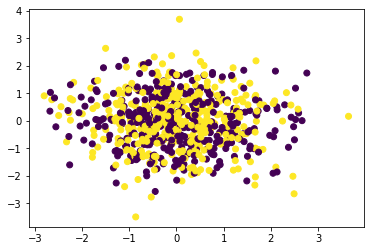

In [7]:
X, y = make_classification(1000, class_sep = 0.8)
X_train, X_test, y_train, y_test = train_test_split(X, y)
plt.scatter(X_train[:,  0], X_train[:,  1], c=y_train)

In [8]:
class MyNN(nn.Module):
    def __init__(self):
        super(MyNN, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 32), nn.Tanh(),
            #nn.Linear(32, 16), nn.Tanh(),
            nn.Linear(32, 2)
        )
    
    def forward(self, x):
        return self.model(x)
    
def train_nn(train_dataloader, epochs=20):
    criterion = nn.CrossEntropyLoss()
    my_nn = MyNN()

    optimizer = torch.optim.Adam(my_nn.parameters(), lr = 0.01)
    for epoch in range(epochs):
        for X, y in train_dataloader:
            optimizer.zero_grad()
            y_hat = my_nn(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
    return my_nn

def train_bnn(train_dataloader, my_nn):
    la = Laplace(my_nn, 'classification',
             subset_of_weights='all',
             hessian_structure='full')
    la.fit(train_dataloader)
    return la

def model_eval(model, dataloader):
    softmax = nn.Softmax(dim=0)
    result = []
    num_samples=0
    for X, y in dataloader:
        result.append((torch.argmax(softmax(model(X)), dim=1) == y).int().numpy())        
        num_samples+=X.shape[0]
    return np.sum(np.concatenate(result)) / num_samples 

In [43]:
def al(batch_size=200):
    #X, y = make_classification(n_samples=5000, n_features=20, class_sep = 1, n_informative=18, n_redundant=2, n_classes=5)
    X, y =sklearn.datasets.make_moons(n_samples=500, shuffle=True, noise=0.1, random_state=None)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    #plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
    #plt.show()
    scores_random, scores_active = list(), list()
    
    sizes = np.arange(batch_size, X_train.shape[0], step=batch_size)
    
    dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(y_train))
    dataset_test = TensorDataset(torch.tensor(X_test, dtype=torch.float), torch.tensor(y_test))
    
    full_dataloader = DataLoader(dataset_test, batch_size = batch_size)

    al_indices = np.arange(sizes[0])
    al_indices_left = np.setdiff1d(np.arange(X_train.shape[0]), al_indices)

    ds_al_train = Subset(dataset, range(batch_size))
    ds_al_test = Subset(dataset, range(batch_size, X_train.shape[0]))
    scores_active = []
    scores_random = []

    for train_dataset_size in sizes:
        #print(f"train lengt {len(ds_al_train)} and predict length = {len(ds_al_test)}")
        train_loader_al = DataLoader(ds_al_train, batch_size=batch_size)
        predict_loader_al = DataLoader(ds_al_test, batch_size=batch_size)

        train_loader = DataLoader(dataset, batch_size=batch_size,
                                  sampler=SubsetRandomSampler(range(train_dataset_size)))
        predict_loader = DataLoader(dataset, batch_size=batch_size,
            sampler = SubsetRandomSampler(range(train_dataset_size, X_train.shape[0]))
        )

            
        #print(f"random {train_dataset_size}, preds = {len(range(train_dataset_size, X_train.shape[0]))}")

        my_nn_al = train_nn(train_loader_al)
        my_bnn = train_bnn(train_loader_al, my_nn_al)
        
        my_nn = train_nn(train_loader)
        
        scores_active.append(model_eval(my_nn_al, full_dataloader))
        scores_random.append(model_eval(my_nn, full_dataloader))
       # print(sizes)
        if train_dataset_size == sizes[-1]:
            break
        pred_vars = []
        for X, y in predict_loader_al:
            a = my_bnn.predictive_samples(X, pred_type='nn', n_samples= 100)
            pred_vars.append(#torch.var(torch.var(a, dim = 2), dim=0).numpy())
                torch.max(torch.var(a, dim=0), dim=1)[0].numpy() -
                torch.min(torch.var(a, dim=0), dim=1)[0].numpy()
            )
#         print(torch.max(torch.var(a, dim=0), dim=1)[0].numpy() -
#                 torch.min(torch.var(a, dim=0), dim=1)[0].numpy())
        pred_vars_np = np.concatenate(pred_vars)
        idxs = pred_vars_np.argsort()
        start = len(idxs) //2 
        start = len(idxs) -  batch_size 
        
        #print(pred_vars_np[idxs])
        #print(pred_vars_np[idxs[-batch_size:]])
        inc = idxs[start:start + batch_size] 

        exc = np.hstack((idxs[:start], idxs[start+batch_size:]))
        ds_al_train = torch.utils.data.ConcatDataset(
            (ds_al_train, Subset(ds_al_test, inc))
        )
        ds_al_test = Subset(ds_al_test, np.setdiff1d(np.arange(len(ds_al_test)), exc))
        
    return sizes, scores_random, scores_active

jestem


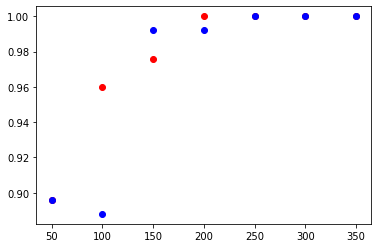

In [44]:
fig, ax = plt.subplots()
sizes, scores_random, scores_active = al(50)
print("jestem")
ax.scatter(sizes, scores_random, c='red')
ax.scatter(sizes, scores_active, c='blue')

In [45]:
x, y =sklearn.datasets.make_moons(n_samples=100, shuffle=True, noise=0.2, random_state=None)

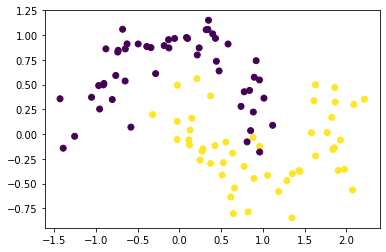

In [46]:
plt.scatter(x[:,0], x[:,1], c=y)

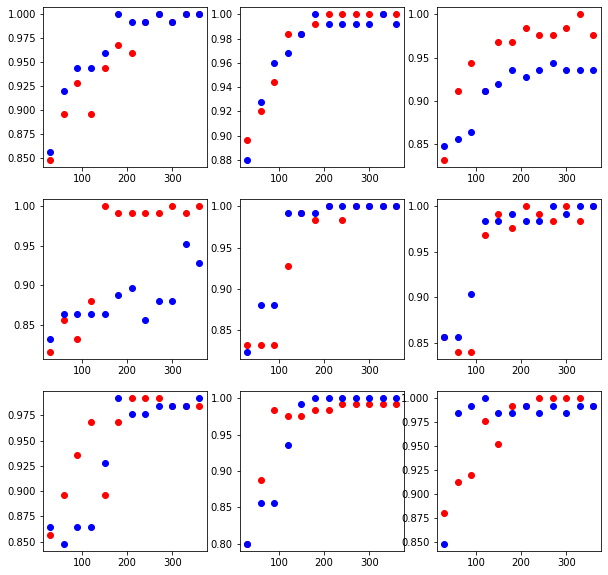

In [47]:
fig, axs = plt.subplots(3,3, figsize=(10,10))
for ax in axs.flatten():
    sizes, scores_random, scores_active = al(30)
    ax.scatter(sizes, scores_random, c='red')
    ax.scatter(sizes, scores_active, c='blue')

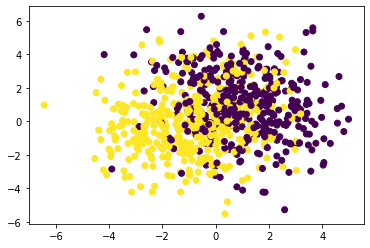

In [14]:
X, y = make_classification(n_samples=1000, n_features=10, class_sep = 0.9, n_informative=10, n_redundant=0)
X_train, X_test, y_train, y_test = train_test_split(X, y)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)